# Проект решения задачи матчинга (соответствия)

## Описание проекта

В данном проекте перед нами стоит базовая задача матчинга (соответствия). Она состоит в следующем:

<u>**Дано:**</u>

Два множества объектов: A и B. Каждый объект в множества описывается какими-то признаками.

<u>**Желаемый результат:**</u>

Для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по некоторой заданной метрике.

### Описание данных

Нам доступны следующие входные данные для решения задачи:

* ***base.csv*** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* ***train.csv*** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

* ***validation.csv*** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* ***validation_answer.csv*** - правильные ответы к предыдущему файлу.

### Описание задачи

* разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

* оценить качество алгоритма по метрике accuracy@5


# Импорты и згрузки

Загружаем все необходимые библиотеки и установки:

In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
import time
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans

Техническая команда для вывода всех столбцов из датасетов:

In [ ]:
pd.set_option('display.max_columns', None)

Подготовливаем словарь для корректной загрузки типов данных.

Вместо типа данных *float64*, который используется в Pandas по умолчанию, будет использовать болеее "лёгкий" тип данных - *float32*.

Поле с целевым признаком в в тренировочном датасете ссылается на id товара, представляющего из себя текстовое значение. Поэтому таргет преобразовываем в *str*.

In [ ]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

## Обзор данных

Загружаем все доступные нам датафреймы:

In [ ]:
df_base = pd.read_csv(r'C:\Users\User\Downloads\data\base.csv', index_col=0, dtype=dict_base)
df_train = pd.read_csv(r'C:\Users\User\Downloads\data\train.csv', index_col=0, dtype=dict_train)
df_validation = pd.read_csv(r'C:\Users\User\Downloads\data\validation.csv', index_col=0, dtype=dict_base)
df_validation_answer = pd.read_csv(r'C:\Users\User\Downloads\data\validation_answer.csv', index_col=0, dtype='str')

Пропишем функцию, которая выдаст нам всю основную и необходимую для нас информацию по датасетам:

In [ ]:
def get_data_info(data):
    display(data.info())
    display(data.shape)
    display(data.head())
    display(data.isna().sum())
    display(data.describe().T)

Посмотрим краткий обзор на наши данные:

In [ ]:
get_data_info(df_base)

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


None

(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,-124.061508,-32.458237,-57.420559,36.207405,182.716766,-28.071688,-5.209374,-1.732183,-91.091858,-79.466667,-103.939087,1507.231323,-32.591667,51.414360,-51.905361,813.770081,-41.556538,8.419807,-129.976639,148.765030,-10.069234,-143.005035,79.848694,-537.183716,2.773180,111.518677,4.257666,-153.340576,-123.626083,-39.707664,-12.768708,-4.170106,-152.967133,75.911522,-57.470089,17.266476,-98.871155,-138.067535,91.000381,-170.701996,-50.020390,59.794296,78.106377,-89.375725,89.412102,79.812180,-129.513611,-44.659496,-80.442207,5.149714,-64.518951,-138.777634,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,-141.304352,-126.768898,-68.853531,8.314717,143.081741,8.778257,15.157185,48.246361,-244.954865,-80.279419,-81.788040,429.880035,-5.937690,70.142654,66.576843,813.770081,3.214371,17.164303,-39.418385,148.155884,-7.579590,-174.369949,101.224632,-303.939240,16.914631,53.394676,33.451824,-148.552628,-110.340172,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948471,62.484821,-166.473358,-189.010422,-56.731556,-30.027319,59.171059,-56.711540,63.542606,-121.319168,97.426056,74.832840,-138.777054,58.887608,-71.595337,-251.952362,11.392853,-148.571655,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,-140.822449,-22.486748,-51.666988,2.521726,140.585449,-22.039230,-7.128633,-5.184787,-111.712120,-79.029266,-82.452576,1507.231323,-0.421011,84.108009,63.344509,813.770081,-105.211052,18.844700,-94.789474,151.387711,-21.483440,-144.845367,48.502934,-780.449158,64.767311,79.781555,-13.390142,-150.061661,-118.758553,-40.896286,-15.222620,-1.860338,-93.820656,98.749069,-46.745781,65.927475,-10.286392,-125.321373,21.048609,-22.637775,68.915985,-54.902260,66.335472,-142.927917,83.030983,69.979630,-123.733887,65.320877,-114.037178,-529.396973,-101.581375,-134.658218,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,-108.470444,-104.537781,-82.388489,-79.986740,113.596313,-38.995880,-4.787360,8.327808,-124.855759,-79.109016,-107.943275,1479.170532,-125.271614,24.656485,-16.921055,813.770081,-182.680267,14.715704,-62.932701,151.201981,10.613454,-134.934341,58.777729,-529.295044,43.665924,92.806305,-38.936657,-145.045303,-124.295769,-36.876732,-17.742870,10.536242,-124.584152,121.914146,-17.321358,105.217239,-94.379646,-63.769272,29.217487,-26.423973,5.869829,64.061546,63.513279,-112.258102,80.926590,72.636101,-137.314316,7.912551,-62.188919,-540.321045,-89.588715,-149.326691,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,-110.342453,-38.982059,-50.228867,-26.690920,135.272903,-7.510103,8.924209,111.576950,-130.833191,-79.315849,-57.843952,1262.919678,19.225910,59.811813,76.159668,312.698914,-76.726974,21.299923,-24.069107,167.385529,-44.059471,-148.131851,98.042610,-657.524414,96.363167,71.061523,-36.563557,-135.372437,-123.708977,-44.739437,-10.855220,8.354800,-168.328857,215.928070,-32.975979,66.864883,30.838631,-211.540375,57.695343,-67.822632,-29.38913

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229462,24.862490,-199.468704,-103.065437,-86.231499,-69.256577,21.515549
1,2918139.0,8.080074,4.947649,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580791,38.586048,-240.073395,-69.559486,-43.816605,-19.625266,160.937225
3,2918139.0,-146.635010,19.821659,-232.667145,-159.905060,-146.776810,-133.327652,-51.374779
4,2918139.0,111.316582,46.283230,-105.582962,80.507946,111.873001,142.374275,319.664490
...,...,...,...,...,...,...,...,...
67,2918139.0,23.544888,55.273884,-233.138168,-12.516241,23.416494,59.755114,314.898773
68,2918139.0,74.959343,61.261200,-203.601624,33.775736,74.929970,115.876041,339.573853
69,2918139.0,115.566696,21.145863,15.724480,101.686668,116.024445,129.552376,214.706345
70,2918139.0,-799.339294,381.932007,-1297.931519,-1074.464844,-1074.464844,-505.744446,98.770813


In [ ]:
get_data_info(df_train)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

None

(100000, 73)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,-88.082687,-52.695541,-27.692442,4.872923,198.348007,-30.075249,-3.803569,-135.810608,-161.841370,-78.512177,-94.428940,898.436951,-70.140518,78.420357,108.032776,813.770081,-74.790878,12.610422,-183.821838,149.715836,-27.042316,-133.212173,106.420746,-303.939240,48.730789,58.185707,24.250950,-151.224106,-104.282265,-34.492809,-12.587054,2.622891,-120.969917,149.991638,-31.948471,82.314430,-115.830467,-243.309387,6.622036,-132.197662,68.712563,-38.806824,62.937435,-132.654449,89.189026,87.039780,-121.279877,-6.986934,-206.513824,29.485588,-77.029587,-132.386169,-105.427818,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,-177.605804,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267029,-78.659431,-92.761490,353.157745,-34.744545,82.487106,-28.450592,813.770081,-137.529633,26.595627,-136.783447,153.357910,48.810093,-115.922150,87.464218,-222.286362,25.124149,91.887138,-30.636869,-136.593140,-140.500122,-43.449757,-7.226884,8.265747,-117.915466,149.150894,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061081,-7.139753,75.862396,-112.045113,82.857727,54.067215,-134.005386,-26.142574,-214.632111,-457.848450,21.459618,-137.411362,-40.812233,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,-86.346558,-35.666546,16.395317,-80.802849,137.908646,-23.532761,-47.256584,-16.650242,-194.505676,-78.372925,-69.324478,1507.231323,-52.500969,-34.165775,52.958652,813.770081,-18.021725,20.951107,-50.321781,158.760620,0.178065,-183.069672,99.053574,-1018.469543,-51.801121,97.766769,-10.865850,-144.423157,-133.819489,-78.902298,-17.200352,4.467452,-63.970737,154.639526,-30.211615,48.527401,-122.406639,-112.713623,53.461838,-31.117260,107.841507,16.482935,77.934479,-95.618729,91.460075,63.119511,-126.939247,8.066628,-195.677673,-163.119995,-72.830002,-139.223068,-52.031662,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,-146.517075,-159.469849,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789322,-78.737091,1507.231323,19.957405,34.834290,-8.820732,813.770081,-125.606796,17.584084,-58.452904,141.281799,-54.959309,-136.988541,63.880493,-1018.469543,89.228928,65.919960,-24.078644,-152.334106,-91.199379,-28.225389,-4.767386,0.158236,-129.128662,122.958366,-30.800995,123.623398,-37.540867,-72.139801,71.240990,-168.115585,118.236450,-18.065195,37.255718,-137.691040,87.500771,62.437290,-131.260635,35.692661,-86.038834,-379.339081,-153.465775,-131.198288,-61.567047,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,-107.153023,-8.800034,-50.977798,29.457338,143.389313,5.614824,-45.274761,9.643625,-77.554626,-79.066612,-77.926460,1507.231323,16.612400,116.284286,33.754898,813.770081,-105.765335,6.523008,-19.812988,157.693924,-20.604088,-146.591278,78.849571,-780.449158,87.560768,73.036659,16.891029,-144.657898,-116.122147,-19.353254,-7.709266,-5.394988,-140.252121,193.184967,-53.

0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.328667,25.803650,-186.280273,-103.309149,-85.273697,-67.330811,14.585236
1,100000.0,7.664345,4.955601,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.0,-43.667046,39.110588,-224.896057,-69.494486,-42.830246,-17.713690,128.108459
3,100000.0,-146.118637,20.434750,-223.307220,-160.028522,-146.067444,-132.277744,-60.751625
4,100000.0,111.770592,47.700665,-93.272018,79.474319,112.260101,143.760826,301.363586
...,...,...,...,...,...,...,...,...
67,100000.0,23.029278,55.470402,-203.746384,-14.144571,23.441362,59.941065,266.493317
68,100000.0,73.412071,62.202408,-181.973816,31.685547,72.880192,114.469225,319.867523
69,100000.0,115.189728,21.582062,22.598862,100.589325,115.236633,129.791080,201.761261
70,100000.0,-709.761536,405.998566,-1297.871948,-1074.464844,-808.801697,-357.087334,98.768234


In [ ]:
get_data_info(df_validation)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

None

(100000, 72)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,-131.892807,-140.968567,-57.987164,-22.868887,150.895523,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579521,263.363129,56.266876,66.924713,21.609911,813.770081,-32.782940,20.794031,-79.779076,156.307083,-42.831329,-71.723335,83.283661,-304.174377,1.609402,55.834587,-29.474255,-139.162766,-126.038353,-62.643829,-5.012346,11.984921,-43.084946,190.123993,-24.996635,76.153900,-245.261566,-143.656479,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697319,60.475632,-127.486870,-39.484753,-124.384575,-307.949768,45.506813,-144.190948,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,-153.717255,-63.951328,-52.369495,-33.390945,148.619507,-22.483829,15.164185,-56.202000,-153.614380,-79.831825,-101.055481,1203.537109,81.597130,101.018654,56.783424,92.209625,-126.860336,10.382887,-38.523361,165.383911,-77.840485,-169.538681,103.483238,-915.735718,16.109938,14.669937,-38.707085,-149.538376,-138.792923,-36.076176,-2.781422,2.283144,-142.477890,189.953949,-18.408230,90.517052,-95.530998,-259.636047,52.437836,-30.004599,14.502060,-1.071201,66.842667,-161.279892,94.794174,50.419983,-125.075256,-25.169033,-176.176880,-655.836914,-99.238373,-141.535217,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,-220.309540,-31.378445,-8.788761,2.285323,133.266113,-41.309078,14.305538,-18.231812,-205.533707,-78.160309,-96.607674,1507.231323,-5.964200,34.937443,-56.086887,813.770081,-13.200474,18.966661,-35.110191,151.368500,-17.490252,-145.884293,15.533379,-655.395508,39.412827,62.554955,9.924992,-143.934616,-123.107796,-37.032475,-13.501337,12.913328,-116.038017,176.276154,-45.909943,103.491364,-90.656990,-162.615707,117.128235,13.079479,69.826889,-6.874451,63.707214,-123.851067,91.610817,59.760067,-129.566177,-12.822194,-154.197647,-407.199066,5.522629,-126.812973,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,-114.271957,-71.406456,-65.349319,24.377069,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690697,-139.227448,325.547119,3.632292,74.929504,-4.802103,813.770081,-52.982597,15.644382,-54.087467,151.309143,21.088570,-134.507889,65.118958,-529.295044,131.565521,67.642700,-22.884491,-145.906525,-86.917328,-11.863579,-22.188885,0.463720,-212.533752,170.522583,-48.092533,99.712555,-194.692413,-141.523178,60.217049,73.386383,118.567856,58.900810,55.569031,-181.091660,83.340485,66.083237,-114.048866,-57.156872,-56.335075,-318.680054,-15.984783,-128.101334,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,-76.214172,-26.393860,34.423641,50.938889,157.683182,-23.786497,-33.175415,-0.592607,-193.318542,-79.651031,-91.889786,1358.481079,44.027733,121.527206,46.182999,433.623108,-82.233200,21.068508,-32.940117,149.268951,0.404718,-97.674530,81.719994,-825.644775,9.397169,49.359341,17.725466,-160.168152,-129.367950,-55.532898,-2.597821,-0.226103,-41.369141,92.090195,-58.626858,73.655441,-10.257370,-175.656784,

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.302231,25.777214,-190.353333,-103.231791,-85.296745,-67.422104,14.427986
1,100000.0,7.669724,4.956953,-11.109877,4.292425,7.657888,10.993900,27.409784
2,100000.0,-43.842476,39.138523,-217.538422,-69.680916,-43.230835,-17.765821,134.859802
3,100000.0,-146.119812,20.495346,-220.050888,-160.210285,-146.080368,-132.119274,-57.381889
4,100000.0,111.635078,47.751408,-81.198990,79.101917,111.959332,143.903732,302.065369
...,...,...,...,...,...,...,...,...
67,100000.0,23.250780,55.403278,-210.672806,-13.863008,23.508739,60.154776,251.288589
68,100000.0,73.114449,62.055851,-175.921783,31.494841,72.152397,114.317055,305.937531
69,100000.0,115.196938,21.492920,25.271042,100.538860,115.280991,129.770218,201.599976
70,100000.0,-709.457031,405.656281,-1297.923950,-1074.464844,-807.029694,-358.400482,98.737076


In [ ]:
get_data_info(df_validation_answer)

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


None

(100000, 1)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Expected    0
dtype: int64

,count,unique,top,freq
Expected,100000,91502,210304-base,7


Проверим данные на явные дубликаты и пропущенные значения:

In [ ]:
df_base.duplicated().sum()

0

In [ ]:
df_base.isna().sum().sort_values(ascending=False)

0     0
1     0
52    0
51    0
50    0
     ..
23    0
22    0
21    0
20    0
71    0
Length: 72, dtype: int64

### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы:

* все признаки, кроме признака **Target** обучающей выборки - численные, **Target** формально можно отнести к категориальным;
* пропущенные значения признаков и явные дубликаты в датафреймах отсутствуют;
* в датафреймах **df_base** и **df_validation** одинаковое количество признаков - 72, в датафрейме **df_validation_answer**, который содержит только целевой признак для тестовой выборки, а датафрейм **df_train** сожержит в себе 72 признака + 1 целевой;
* базовый датасет имеет почти **3 миллиона объектов**, все остальные датасеты имеют ровно **100 тысяч строк**.

Перейдем к следующему шагу - решение задачи мэтчинга и замер метрики.

## Базовое решение задачи мэтчинга и первый замер метрики

Создадим индекс для **df_base** с помощью библиотеки faiss.

In [ ]:
dims = df_base.shape[1]    # размерность вектора признаков
n_cells = 10    # количество кластеров
quantizer = faiss.IndexFlatL2(dims)    # создание квантайзера с использованием L2 (евклидовой) метрики
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

Теперь обучим индекс на выборке из 50000 объектов и добавим в индекс наши вектора признаков.

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

Создадим индекс из исходного базового датасета (его колонки "индекс") для удобства работы в дальнейшем.

In [ ]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Выделим целевой признак из **df_train** в отдельную переменную *targets*, а сам столбец удалим из тренировочного датасета. Это необходимо для дальнейшей корректного поиска ближайших соседей.

In [ ]:
targets_train = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

Выполним поиск ближайших соседей, с учетом того, что нам необходимо найти 5 похожих объектов.

In [ ]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train).astype('float32'), 5)

CPU times: total: 42min 28s
Wall time: 6min


Пропишем функцию для замера метрики accuracy@5, которая на вход будет принимать вектор правильных ответов (значения целевого признака), вектор индексов ближайших соседей и базовый вектор индексов, ранее созданный, а на выходе - выдавать значение требуемой метрики.

In [ ]:
def acc_5(targets, indices, base_indices):

    acc = 0 # начальное значение метрики
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in el])

    return 100 * acc / len(indices)

In [ ]:
print(acc_5(targets_train, idx, base_index), '%')

12.623 %


### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы, что базовое решение задачи мэтчинга дает значение метрики *12,62%* - очень низкий показатель, который необходимо повышать. Для улучшения качества решения задачи требуется выполнить предобработку данных и необходимый исследовательский анализ (EDA) обучающего и тестового датасета.

Перейдем к следующему шагу - предобработке данных и повышения качества метрики.

## Предобработка и повышение качества метрики

Построим гистограммы по каждому из столбцов и посмотрим на то, как распределяются значения признаков.

Учитывая большие объёмы данных в датасетах, построим графики на ограниченной выборке - 10 тысяч случайных значений. На общую картину это значительно не повлияет, зато сократит время выполнения операции:

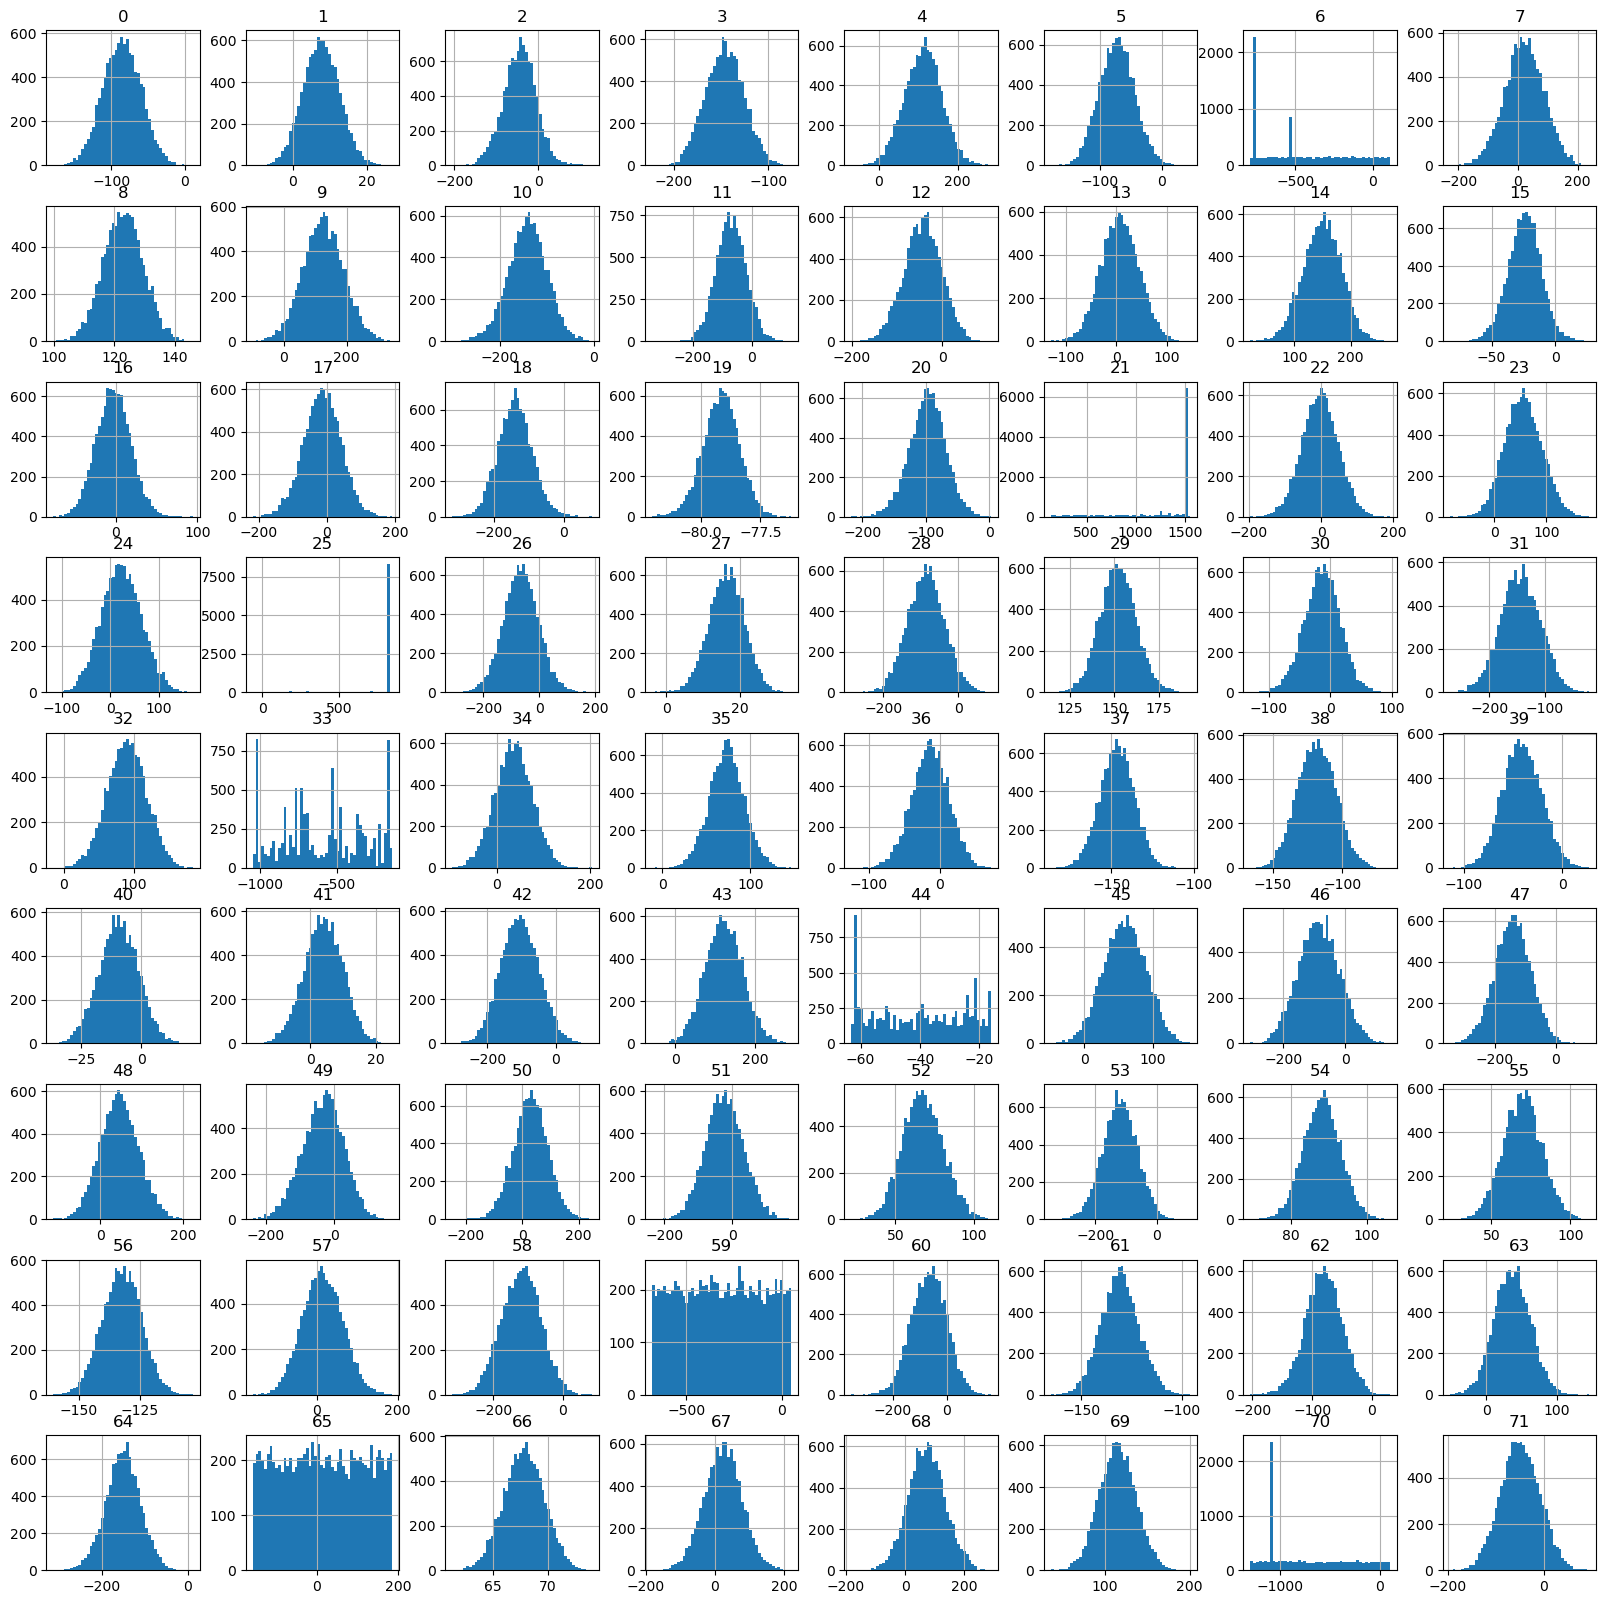

In [ ]:
df_samples = df_train[:10000]

df_samples.hist(figsize=[20, 20], bins=50);

Видим, что ряд признаков имеет не нормальной распределение, а именно: 6, 21, 25, 33, 44, 59, 65 и 70.

Проверим насколько признаки, которые в исходном виде не имеют нормального распределния, влияют на качество метрики. Попробуем избавиться от этих признаков и вновь запустить замер метрики:

In [ ]:
df_base_del = df_base.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
df_train_del = df_train.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
df_validation_del = df_validation.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)

In [ ]:
dims = df_base_del.shape[1]    # размерность вектора признаков
n_cells = 10    # количество кластеров
quantizer = faiss.IndexFlatL2(dims)    # создание квантайзера с использованием L2 (евклидовой) метрики
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_del.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del.values).astype('float32'))

In [ ]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_del).astype('float32'), 5)

CPU times: total: 37min 40s
Wall time: 5min 38s


In [ ]:
print(acc_5(targets_train, idx, base_index), '%')

61.911 %


Видим, что метрика значительно улучшила свои показания: с *12,63%* она поднялась до *61,91%*.

Продолжим преобразование и выполним масштабирование численных признаков в полученных датафреймах признаков с помощью инструмента  RobustScaler. Масштабирование выполним следующим образом: обучим скэйлер на базовой выборке, а потом применим его для преобразования признаков из обучающей и тестовой выборок.

In [ ]:
scaler = RobustScaler()
df_base_scaler = pd.DataFrame(scaler.fit_transform(df_base_del), index=df_base_del.index)
df_train_scaler = pd.DataFrame(scaler.transform(df_train_del), index=df_train_del.index)
df_validation_scaler = pd.DataFrame(scaler.transform(df_validation_del), index=df_validation_del.index)

In [ ]:
dims = df_base_scaler.shape[1]
n_cells = 10
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_scaler.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_scaler.values).astype('float32'))

In [ ]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_scaler).astype('float32'), 5)

CPU times: total: 40min 21s
Wall time: 5min 51s


In [ ]:
print(acc_5(targets_train, idx, base_index), '%')

63.462 %


Показания метрики снова улучшились: нынешний показатель составил *63.46%*.

### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы.

Нам удалось поднять итоговую метрику до значения *63,46%* благодаря следующим действиям:
   * анализ показал, что большинство признаков имеют нормальное распределение, но ряд признаков (под номерами  6, 21, 25, 33, 44, 59, 65 и 70) - имеют распределение, отличное от нормального;
   * признаки, имеющие не нормальное распределение, были удалены, за счёт чего метрика значительно выросла;
   * провели масштабирование численных признаков с помощью инструмента RobustScaler.

## Подбор оптимальный параметров

Определим оптимальное количество кластеров по методу "локтя". Для этого воспользуемся методом библиотеки MiniBatchKMeans.

Для начала отберём 50 тыс. объектов для обучения и построим график.

In [ ]:
base_clust = np.ascontiguousarray(df_base_scaler.values[:50000, :].astype('float32'))

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available thre

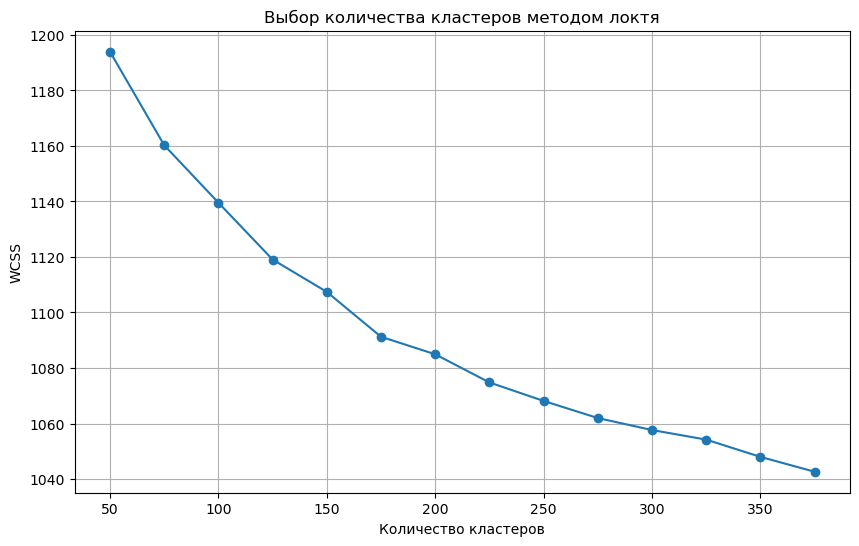

In [ ]:
# создадим пустой список для записи показателя WCSS (нашей ошибки)
wcss = []

for i in range(50, 400, 25):

    # настроим параметры модели
    kmeans = MiniBatchKMeans(n_clusters = i, init = 'random', random_state = 42).fit(base_clust)

    # для каждого кластера рассчитаем ошибку (атрибут inertia_) и поместим в список
    wcss.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize = (10,6))
# передадим функции plot() последовательность кластеров и ошибку WCSS
plt.plot(range(50, 400, 25), wcss, marker='o')
plt.title('Выбор количества кластеров методом локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.grid()
plt.show()

Как видно на графике, когда мы перешли от 225 до 250 кластеров, ошибка стала уменьшаться настолько стремительно, что позволяет нам сделать выбор в оптимальном количестве кластеров равном 225.

Далее методом перебора найдём оптимальное значение параметра nprobe. Остановились на значении 50 - при таком выборе сохраняется достаточно хороший показатель метрики, а также оптимальные показатели скорости прогрузки алгоритма.

In [ ]:
dims = df_base_scaler.shape[1]
n_cells = 225
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.nprobe = 50

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_scaler.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_scaler.values).astype('float32'))

In [ ]:
base_index = {x: v for x, v in enumerate(df_base.index.to_list())}

In [ ]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_scaler).astype('float32'), 5)

CPU times: total: 1h 31min 34s
Wall time: 13min 8s


In [ ]:
print(acc_5(targets_train, idx, base_index), '%')

70.875 %


### Выводы по разделу

По результатам проведенной работы можно сделать следующие предварительные выводы: при подборе оптимального количества кластеров (с помощью метода "локтя") и значения параметра nprobe (методом перебора) смогли добиться повышения метрики на тренировочных данных до значенися *70,88%*.

Далее можем приступить к итоговому замеру метрики на тестовых данных.

## Итоговый замер метрики на тестовых данных

In [ ]:
dims = df_base_scaler.shape[1]
n_cells = 225
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
idx_l2.nprobe = 50

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_scaler.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_scaler.values).astype('float32'))

In [ ]:
base_index = {x: v for x, v in enumerate(df_base.index.to_list())}

In [ ]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(df_validation_scaler).astype('float32'), 5)

CPU times: total: 1h 31min 50s
Wall time: 13min 4s


In [ ]:
print(acc_5(df_validation_answer['Expected'], idx, base_index), '%')

70.784 %


## Вывод

Алгоритм, разработанный с помощью методов библиотеки FAISS, применили на тестовых данных и получили результат метрики accuracy@5 равный *70,784%*. Это значение практически не уступает замеру метрики на тренировочных данных (*70,875%*), поэтому результы на тестовой выборке можем считать успешными.